Autoregressive (AR) models are a cornerstone of time series analysis and are particularly useful in forecasting future values by leveraging past data points. For instance, AR models can be used to predict the atmospheric concentration of carbon dioxide, air temperature, streamflow, air quality, and several other time-dependent environmental variables.

One of the most powerful and commonly used autoregressive models is the ARIMA model, which stands for Autoregressive Integrated Moving Average. This model has three primary components:

1. **AR (Autoregressive) terms** - These are coefficients that multiply lagged values of the series. The AR part uses the dependency between an observation and a number of lagged observations to make predictions.

2. **I (Integrated) terms** - This represents the differencing of observations to make the time series stationary, which means the series has constant mean and variance over time, a prerequisite for AR and MA parts to work.

3. **MA (Moving Average) terms** - These parameters are coefficients that multiply lagged forecast errors in prediction equations. The MA part models the error of the time series, smoothing out the noise.


In this exercise we will use the `statsmodels` library to train and forecast the atmospheric carbon dioxide concentration recorded at the Mauna Loa Observatory in Hawaii, U.S.

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA


## Read and explore dataset

In [2]:
# Define column names
col_names = ['year','month','decimal_date','avg_co2',
             'de_seasonalized','days','std','uncertainty']

# Read dataset with custom column names
df = pd.read_csv('../datasets/co2_mm_mlo.txt', comment='#', delimiter='\s+', names=col_names)

# Display a few rows
df.head(3)


,year,month,decimal_date,avg_co2,de_seasonalized,days,std,uncertainty
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99


In [3]:
# Add date column
df['date'] = pd.to_datetime({'year':df['year'],
                             'month':df['month'],
                             'day':1})

# Set timestamp as index (specify the freq for the statsmodels package)
df.set_index('date', inplace=True)
df.index.freq = 'MS' # print(df.index.freq) to check that is not None
df.head(3)


,year,month,decimal_date,avg_co2,de_seasonalized,days,std,uncertainty
date,,,,,,,,
1958-03-01,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1958-04-01,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
1958-05-01,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99


In [4]:
# Check if we have any missing values
df.isna().sum()


year               0
month              0
decimal_date       0
avg_co2            0
de_seasonalized    0
days               0
std                0
uncertainty        0
dtype: int64

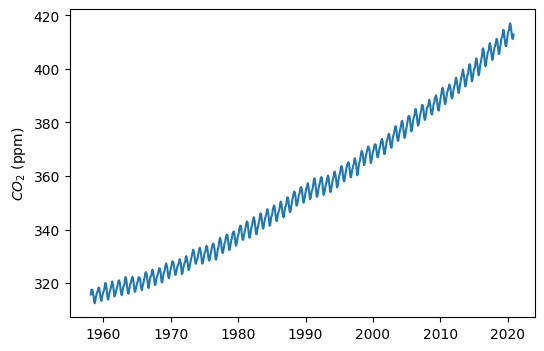

In [5]:
# Visualize time series data
plt.figure(figsize=(6,4))
plt.plot(df['avg_co2'])
plt.ylabel('$CO_2$ (ppm)')
plt.show()


## Test for stationarity

Stationarity in a time series implies that the statistical properties of the series like mean, variance, and autocorrelation are constant over time. In a stationary time series, these properties do not depend on the time at which the series is observed, meaning that the series does not exhibit trends or seasonal effects. Non-stationary data typically show clear trends, cyclical patterns, or other systematic changes over time. Non-stationary time series often need to be transformed (or de-trended) to become stationary before analysis.

The Dickey-Fuller (`adfuller`) test provided by the `statsmodels` library can be helpful to statistically test for stationarity.

**Dickey-Fuller test**
- Null Hypothesis: The series is NOT stationary
- Alternate Hypothesis: The series is stationary.

The null hypothesis can be rejected if `p-value<0.05`.  Hence, if the p-value is >0.05, the series is non-stationary.


In [6]:
# Dickey-Fuller test
results = adfuller(df['avg_co2'])
print(f"p-value is {results[1]}")


p-value is 1.0


## Create training and testing sets

Let's use 95% of the dataset to fit the model and the remaining 5%, more recent, observations to test our forecast.

In [7]:
# Train and test sets
idx_train = df['year'] < 2017
df_train = df[idx_train]
df_test = df[~idx_train]


## Decompose time series

In [8]:
# Decompose time series
# Extrapolate to avoid NaNs
results = seasonal_decompose(df_train['avg_co2'], 
                             model='additive', 
                             period=12,
                             extrapolate_trend='freq')
 

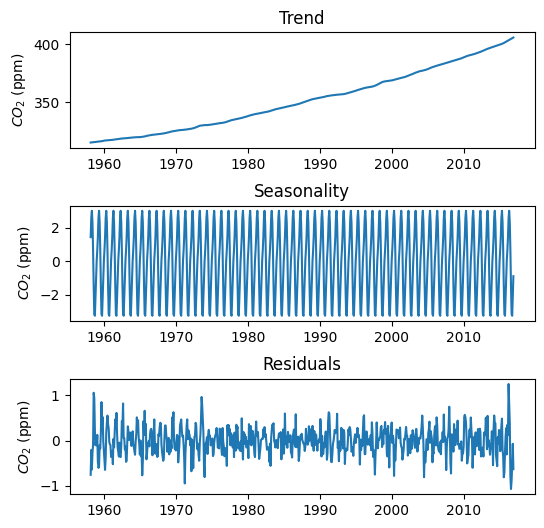

In [9]:
# Create figure with trend components
plt.figure(figsize=(6,6))
 
plt.subplot(3,1,1)
plt.title('Trend')
plt.plot(results.trend, label='Trend')
plt.ylabel('$CO_2$ (ppm)')
 
plt.subplot(3,1,2)
plt.title('Seasonality')
plt.plot(results.seasonal, label='Seasonal')
plt.ylabel('$CO_2$ (ppm)')

plt.subplot(3,1,3)
plt.title('Residuals')
plt.plot(results.resid, label='Residuals')
plt.ylabel('$CO_2$ (ppm)')

plt.subplots_adjust(hspace=0.5)
plt.show()

## Examine autocorrelation lags

The `statsmodels` module offers an extensive library of functions for time series analysis. In addition to autocorrelation function, we can also apply a partial autocorrelation function, that removes the effect of intermediate lags. For instance, the PACF between time `t` and time `t-4` is the pure autocorrelation without the effect of `t-1`, `t-2`, and `t-3`. Autocorrelation plots will help us define the number of lags that we need to consider in our autoregressive model.

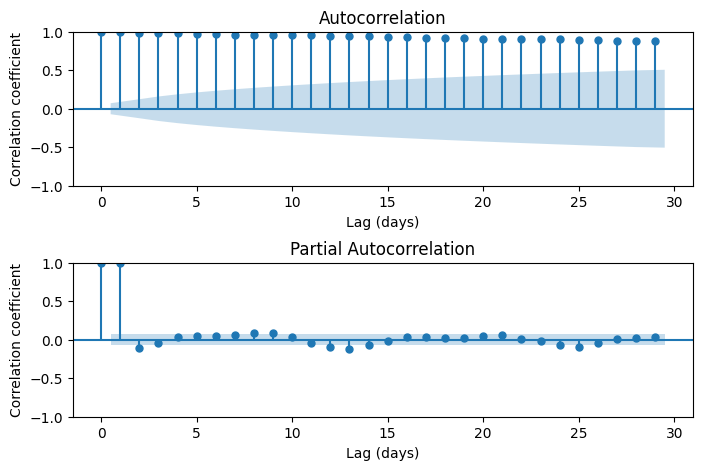

In [24]:
# Create figure
fig, ax = plt.subplots(figsize=(8,5), ncols=1, nrows=2)

# Plot the autocorrelation function
plot_acf(df['avg_co2'], ax=ax[0])
ax[0].set_xlabel('Lag (days)')
ax[0].set_ylabel('Correlation coefficient')

# Plot the partial autocorrelation function
plot_pacf(df['avg_co2'], ax[1], method='ywm')
ax[1].set_xlabel('Lag (days)')
ax[1].set_ylabel('Correlation coefficient')

fig.subplots_adjust(hspace=0.5)
plt.show()


In [25]:
# Fit model to train set
model = ARIMA(df_train['avg_co2'],
              order=(1,0,0), 
              seasonal_order=(1,0,0,12),
              dates=df_train.index,
              trend=[1,1,1]
             ).fit()

# (p,d,q) => autoregressive, differences, and moving average
# (p,d,q,s) => autoregressive, differences, moving average, and periodicity
# seasonal_order (3,0,0,12) means that we add 12, 24, and 36 month lags

In [29]:
# Mean absolute error against the train set
print(f"MAE = {model.mae} ppm")


MAE = 0.3244007587766971 ppm


In [30]:
# Print summary statistics
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          avg_co2   No. Observations:                  706
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -820.999
Date:                          Thu, 01 Feb 2024   AIC                           1653.998
Time:                                  10:47:03   BIC                           1681.355
Sample:                              03-01-1958   HQIC                          1664.569
                                   - 12-01-2016                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        314.2932     60.601      5.186      0.000     195.518     433.069
x1             0.0663      0.170      0.389      0.697      -0.268       0.400
x2          8.585e-05      0.000      0.497      0.619      -0.000       0.000
ar.L1          0.8454      0.156      5.413      0.000       0.539       1.152
ar.S.L12       0.9696      0.019     50.944      0.000       0.932       1.007
sigma2         1.3816      0.117     11.799      0.000       1.152       1.611
===================================================================================
Ljung-Box (L1) (Q):                  35.92   Jarque-Bera (JB):                 3.15
Prob(Q):                              0.00   Prob(JB):                         0.21
Heteroskedasticity (H):               1.15   Skew:                             0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

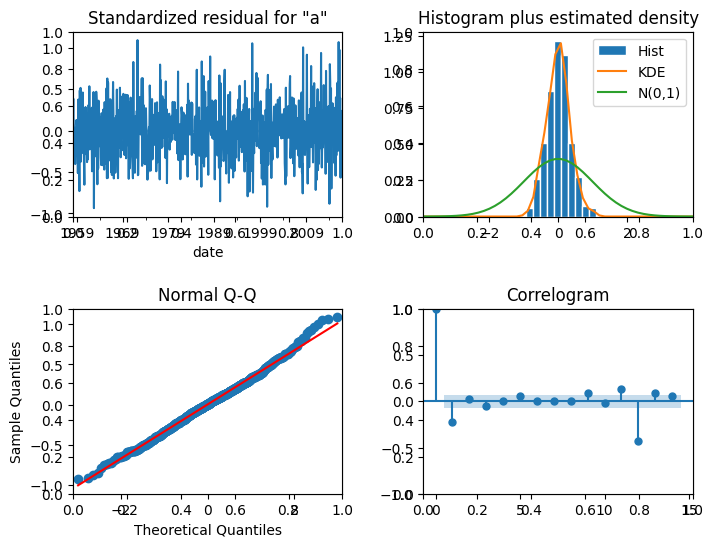

In [31]:
# Plot diagnostic charts
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
model.plot_diagnostics(lags=14, fig=fig)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()


## Predict with autoregressive model

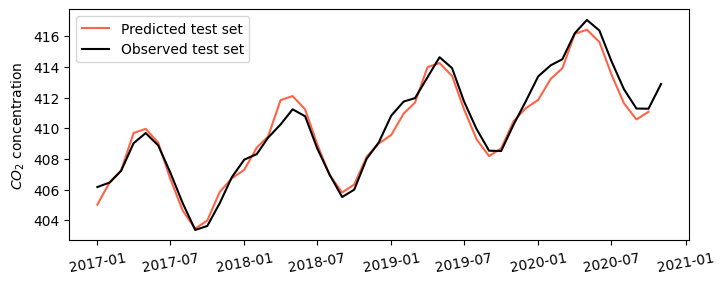

In [21]:
# Predict values for the remaining 5% of the data
pred_values = model.predict(start=df_test.index[0], end=df_test.index[-2])

# Create figure
plt.figure(figsize=(8,3))
plt.plot(pred_values, color='tomato', label='Predicted test set')
plt.plot(df_test['avg_co2'], color='k', label='Observed test set')
plt.ylabel('$CO_2$ concentration')
plt.xticks(rotation=10)
plt.legend()
plt.show()


In [32]:
# Mean absolute error against test set
mae_predicted = np.mean(np.abs(df['avg_co2'] - pred_values))
print(f'MAE = {mae_predicted:.2f} ppm')

MAE = 0.50 ppm


## Create 2030 forecast

Concentration in 2030 is expected to be: 439 ppm


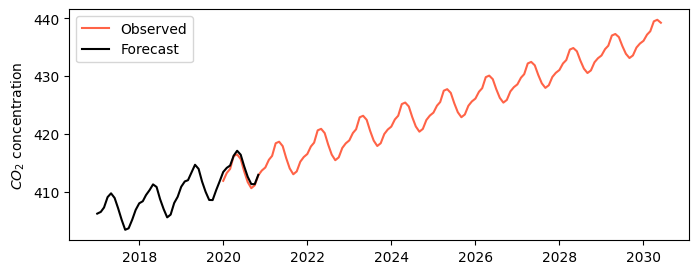

In [35]:
# Forecast  concentration until 2030
forecast_values = model.predict(start=pd.to_datetime('2020-01-01'), 
                            end=pd.to_datetime('2030-06-01'))

# Print concentration in 2030
print(f'Concentration in 2030 is expected to be: {forecast_values.iloc[-1]:.0f} ppm')

# Create figure
plt.figure(figsize=(8,3))
plt.plot(forecast_values, color='tomato', label='Observed')
plt.plot(df_test['avg_co2'], color='k', label='Forecast')
plt.ylabel('$CO_2$ concentration')
plt.legend()
plt.show()
